In [1]:
#Link to dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression
#Paper describing the original data collection: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0119491#sec002

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
raw_data = pd.read_excel('Data_Cortex_Nuclear.xls')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 82 columns):
MouseID            1080 non-null object
DYRK1A_N           1077 non-null float64
ITSN1_N            1077 non-null float64
BDNF_N             1077 non-null float64
NR1_N              1077 non-null float64
NR2A_N             1077 non-null float64
pAKT_N             1077 non-null float64
pBRAF_N            1077 non-null float64
pCAMKII_N          1077 non-null float64
pCREB_N            1077 non-null float64
pELK_N             1077 non-null float64
pERK_N             1077 non-null float64
pJNK_N             1077 non-null float64
PKCA_N             1077 non-null float64
pMEK_N             1077 non-null float64
pNR1_N             1077 non-null float64
pNR2A_N            1077 non-null float64
pNR2B_N            1077 non-null float64
pPKCAB_N           1077 non-null float64
pRSK_N             1077 non-null float64
AKT_N              1077 non-null float64
BRAF_N             1077 non-null 

In [4]:
# Most column names are protein names; the ones that aren't are MouseID, class, Genotype, Treatment, and Behavior.    
# class summarizes Genotype, Treatment, and Behavior
# MouseID includes both mouse ID and measurement number (15 measurements/mouse).
# Separate the Mouse ID from the measurement replicate:
new_cols = ['Mouse','Rep']
data = raw_data.join(pd.DataFrame(list(raw_data['MouseID'].str.split('_')),columns = new_cols))
data.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class,Mouse,Rep
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m,309,1
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m,309,2
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m,309,3
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m,309,4
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m,309,5


In [5]:
# identify which columns represent protein names
not_a_protein = ['Genotype','Behavior','Treatment','class'] + new_cols + ['MouseID']
protein_names = list(set(data.columns.values) - set(not_a_protein)) 
#Note this protein_names list will not be in the same order as the original columns

In [6]:
#Looks like missing values are either (1) a mouse has no measurements for certain proteins or (2) a certain mouse is missing a subset of measuremne
missing_value_counts = data.set_index(not_a_protein).isnull().groupby(['class','Mouse']).sum()
missing_value_counts_subset = missing_value_counts.loc[missing_value_counts.sum(axis=1)!=0,missing_value_counts.sum(axis=0)!=0]
missing_value_counts_subset.info()
#36 mice and 49 proteins are missing at least some data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 36 entries, (c-CS-m, 309) to (t-SC-s, J3295)
Data columns (total 49 columns):
DYRK1A_N      36 non-null float64
ITSN1_N       36 non-null float64
BDNF_N        36 non-null float64
NR1_N         36 non-null float64
NR2A_N        36 non-null float64
pAKT_N        36 non-null float64
pBRAF_N       36 non-null float64
pCAMKII_N     36 non-null float64
pCREB_N       36 non-null float64
pELK_N        36 non-null float64
pERK_N        36 non-null float64
pJNK_N        36 non-null float64
PKCA_N        36 non-null float64
pMEK_N        36 non-null float64
pNR1_N        36 non-null float64
pNR2A_N       36 non-null float64
pNR2B_N       36 non-null float64
pPKCAB_N      36 non-null float64
pRSK_N        36 non-null float64
AKT_N         36 non-null float64
BRAF_N        36 non-null float64
CAMKII_N      36 non-null float64
CREB_N        36 non-null float64
ELK_N         36 non-null float64
ERK_N         36 non-null float64
GSK3B_N       36 non-n

In [7]:
# Check to see how many data points are outliers within a particular Mouse x protein
# preliminarily define outlier as 3 SDs outside the mean.  With a normal distribution, that will only be 0.3% of data points
# this is <1 point per Mouse x protein, but 2455 total. (data[protein_names].count(axis=0).sum() * 0.03)
outlier_sds = 3
means = data.groupby('Mouse').mean()[protein_names]
sds = data.groupby('Mouse').std()[protein_names]
mice = data['Mouse'].unique()
outliers_count = pd.DataFrame(columns=means.columns, index=means.index)
for mouse in mice:
    for protein in protein_names:
        is_outlier = abs(data.loc[data.Mouse == mouse,protein]-means.loc[mouse,protein]) > outlier_sds * sds.loc[mouse,protein]
        outliers_count.loc[mouse,protein] = is_outlier.sum()
outliers_count.sum().sum()

70

In [8]:
outliers = data.copy()
for mouse in mice:
    for protein in protein_names:
        is_outlier = abs(data.loc[data.Mouse == mouse,protein]-means.loc[mouse,protein]) > outlier_sds * sds.loc[mouse,protein]
        outliers.loc[data.Mouse == mouse,protein] = is_outlier
outliers.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class,Mouse,Rep
0,309_1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,Control,Memantine,C/S,c-CS-m,309,1
1,309_2,False,False,False,False,False,False,False,False,False,...,False,False,False,False,Control,Memantine,C/S,c-CS-m,309,2
2,309_3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,Control,Memantine,C/S,c-CS-m,309,3
3,309_4,False,False,False,False,False,False,False,False,False,...,False,False,False,False,Control,Memantine,C/S,c-CS-m,309,4
4,309_5,False,False,False,False,False,False,False,False,False,...,False,False,False,False,Control,Memantine,C/S,c-CS-m,309,5


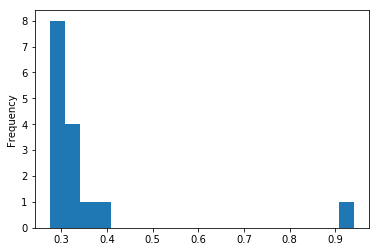

In [9]:
data.loc[780:794,['MouseID','DYRK1A_N']]
data.loc[780:794,'DYRK1A_N'].plot(kind='hist',bins=20)

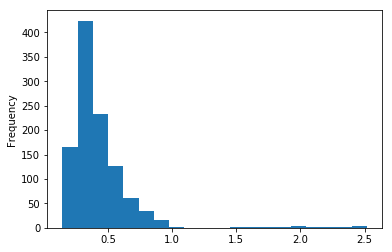

In [10]:
data.loc[:,'DYRK1A_N'].plot(kind='hist',bins=20)

In [11]:
outliers_count.sum()

pCASP9_N           0
MTOR_N             1
ELK_N              0
pCREB_N            0
MEK_N              1
pP70S6_N           3
ITSN1_N            0
pJNK_N             1
PSD95_N            1
BRAF_N             3
SOD1_N             0
SNCA_N             0
BAD_N              0
SYP_N              0
Tau_N              0
pNR2A_N            0
ERK_N              0
AMPKA_N            0
GluR4_N            2
pPKCAB_N           0
NR2B_N             6
TIAM1_N            1
pCFOS_N            1
S6_N               0
PKCA_N             1
AKT_N              2
pGSK3B_N           1
pPKCG_N            0
GFAP_N             2
CAMKII_N           0
                  ..
SHH_N              1
RRP1_N             6
pMEK_N             2
BDNF_N             1
DYRK1A_N           1
JNK_N              2
ARC_N              0
CaNA_N             0
CDK5_N             1
pBRAF_N            5
NUMB_N             0
EGR1_N             0
pNR1_N             0
ERBB4_N            1
H3MeK4_N           0
nNOS_N             0
RSK_N        

In [17]:
outliers.loc[outliers.loc[:,'RRP1_N'],['Mouse','RRP1_N']]

,Mouse,RRP1_N
133,3520,True
298,365,True
448,3422,True
460,3423,True
531,3490,True
877,3483,True
